#Install import

In [ ]:
!pip install geopandas
!pip install geojson
!pip install contextily

In [ ]:
import geopandas as gpd
import geojson as gjs
from geopandas import GeoDataFrame
from shapely.geometry import Point, LineString
import pandas as pd
import matplotlib.pyplot as plt
import json
import contextily as ctx
import re
import numpy as np

from plotly.offline import iplot
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from pandas import json_normalize
from google.colab import data_table
from google.colab import drive
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud import storage
import os



drive.mount('/content/drive/')
%reload_ext google.colab.data_table
%load_ext google.cloud.bigquery

In [ ]:
#----Traigo el query completo desde Big Query-------
%%time
credencial= service_account.Credentials.from_service_account_file(
    '/content/drive/My Drive/Team 80 DS4A/Secretaría de Movilidad - SGV/Dash/secretaria-movilidad-d7884405beb2.json',
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

client= bigquery.Client(
    credentials= credencial,
    project=credencial.project_id,
)


query ='''
SELECT * FROM `secretaria-movilidad.bitcarrier.bitcarrier` 
WHERE fecha >'2020-07-31'

'''

prueba = client.query(query)

df_bitcarrier=prueba.to_dataframe()

CPU times: user 12min 14s, sys: 10.6 s, total: 12min 24s
Wall time: 30min 20s


# Bitcarrier Exploration

In [ ]:
'''
df_bitcarrier_ago = gpd.read_file('/content/drive/My Drive/Team 80 DS4A/Secretaría de Movilidad - SGV/Data_Final/Bitcarrier_5min/velAgosto2020_24h.csv')


df_bitcarrier_sep = gpd.read_file('/content/drive/My Drive/Team 80 DS4A/Secretaría de Movilidad - SGV/Data_Final/Bitcarrier_5min/velseptiembre2020_24h.csv')
df_bitcarrier_oct = gpd.read_file('/content/drive/My Drive/Team 80 DS4A/Secretaría de Movilidad - SGV/Data_Final/Bitcarrier_5min/velOctubre2020_24h.csv')
df_bitcarrier = df_bitcarrier_ago.append([df_bitcarrier_sep, df_bitcarrier_oct]).reset_index()
'''

#Converting types
df_bitcarrier['tid'] = df_bitcarrier['tid'].astype('int64')
df_bitcarrier['speed'] = df_bitcarrier['speed'].astype('float64')
df_bitcarrier['count'] = df_bitcarrier['count'].astype('int')
#Converting time to Date Time type
df_bitcarrier['Datetime'] = pd.to_datetime(df_bitcarrier['fecha'])

In [ ]:
display(df_bitcarrier.info())
print(print(df_bitcarrier.isnull().values.any()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20565418 entries, 0 to 20565417
Data columns (total 9 columns):
 #   Column          Dtype              
---  ------          -----              
 0   tid             int64              
 1   time            datetime64[ns, UTC]
 2   fecha           datetime64[ns, UTC]
 3   levelofservice  object             
 4   speed           float64            
 5   elapsed_time    int64              
 6   count           int64              
 7   year            object             
 8   Datetime        datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](3), float64(1), int64(3), object(2)
memory usage: 1.4+ GB


None

True
None


In [ ]:
data_table.DataTable(df_bitcarrier)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#Read key file
llave_movilidad = pd.read_excel('/content/drive/My Drive/Team 80 DS4A/Secretaría de Movilidad - SGV/TramosCGT-REV.dbf - original.xlsx')
print(llave_movilidad.info())
llave_movilidad

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401 entries, 0 to 400
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   tid          401 non-null    int64         
 1   cartodb_id   401 non-null    int64         
 2   update_at    401 non-null    datetime64[ns]
 3   name_from    401 non-null    object        
 4   name_to      401 non-null    object        
 5   distance     401 non-null    int64         
 6   type         401 non-null    int64         
 7   Tipo         401 non-null    object        
 8   Corredor     401 non-null    object        
 9   Sentido      401 non-null    object        
 10  Observación  4 non-null      object        
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 34.6+ KB
None


tid  cartodb_id  update_at  ...         Corredor Sentido  Observación
0        142         142 2020-02-19  ...  Autopista Norte      NS          NaN
1        141         141 2020-02-19  ...  Autopista Norte      SN          NaN
2         36          36 2020-02-19  ...       Av. Boyacá      SN          NaN
3         35          35 2020-02-19  ...       Av. Boyacá      NS          NaN
4         44          44 2020-02-19  ...     Av. Calle 26      EW          NaN
..       ...         ...        ...  ...              ...     ...          ...
396  1001708     1001708 2020-02-19  ...         Av. Suba      SN          NaN
397  1002026     1002026 2020-02-19  ...         Av. Suba      SN          NaN
398  1000950     1000950 2020-02-19  ...         Av. Suba      SN          NaN
399  1002031     1002031 2020-02-19  ...         Av. Suba      SN          NaN
400  1002029     1002029 2020-02-19  ...         Av. Suba      SN          NaN

[401 rows x 11 columns]

In [ ]:
#Asignar nombres corredores del archivo llave al Dataframe de Bitcarrier
df_bitcarrier_mainroad = pd.merge(df_bitcarrier,llave_movilidad, left_on='tid' ,right_on='tid', how='right')
#df_bitcarrier_mainroad[(df_bitcarrier_mainroad.main_name=='AV.P.MAYO')]
df_bitcarrier_mainroad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8951243 entries, 0 to 8951242
Data columns (total 19 columns):
 #   Column          Dtype              
---  ------          -----              
 0   tid             int64              
 1   time            datetime64[ns, UTC]
 2   fecha           datetime64[ns, UTC]
 3   levelofservice  object             
 4   speed           float64            
 5   elapsed_time    float64            
 6   count           float64            
 7   year            object             
 8   Datetime        datetime64[ns, UTC]
 9   cartodb_id      int64              
 10  update_at       datetime64[ns]     
 11  name_from       object             
 12  name_to         object             
 13  distance        int64              
 14  type            int64              
 15  Tipo            object             
 16  Corredor        object             
 17  Sentido         object             
 18  Observación     object             
dtypes: datetime64[ns, UTC

In [ ]:
df_bitcarrier_mainroad['fecha'].isnull().values.any()


True

In [ ]:
df_bitcarrier_mainroad['count'].sum()

33663362.0

In [ ]:
df_bitcarrier_mainroad['complete_name'] = df_bitcarrier_mainroad['name_from'] + ' - ' + df_bitcarrier_mainroad['name_to']

In [ ]:
#Tag and eliminate the main roads in bitcarrier. We have to eliminate because this "segments" have average speed, count of vehicules of all main road. 
#For our analysis this is not good.

b_dict =[{'complete_name':'AUTONORTE - SANTA.FE;CL80', 'complete_road':'yes'},
{'complete_name':'KR72 - CL43AS;CL170', 'complete_road':'yes'},
{'complete_name':'KR72 - CL170;CL43AS', 'complete_road':'yes'},
{'complete_name':'AV.CARACAS - DIAG48SUR;CL80', 'complete_road':'yes'},
{'complete_name':'AV.CARACAS - CL80;DIAG48SUR', 'complete_road':'yes'},
{'complete_name':'KR7 - CL32;CL188', 'complete_road':'yes'},
{'complete_name':'KR7 - CL188;CL32', 'complete_road':'yes'},
{'complete_name':'NQS - CL100;CL59SUR', 'complete_road':'yes'},
{'complete_name':'NQS - CL59SUR;CL100', 'complete_road':'yes'},
{'complete_name':'AV.P.MAYO - KR80;KR3E', 'complete_road':'yes'},
{'complete_name':'AV.P.MAYO - KR3E;KR80', 'complete_road':'yes'},
{'complete_name':'AV.SUBA - KR94;SAN.MARTIN', 'complete_road':'yes'},
{'complete_name':'AV.SUBA - SAN.MARTIN;KR94', 'complete_road':'yes'},
{'complete_name':'CL26 - AV.CARACAS;MODELIA', 'complete_road':'yes'},
{'complete_name':'CL26 - MODELIA;AV.CARACAS', 'complete_road':'yes'},
{'complete_name':'CL80 - AV.CARACAS;KR119', 'complete_road':'yes'},
{'complete_name':'CL80 - KR119;AV.CARACAS', 'complete_road':'yes'},
{'complete_name':'CL13 - KR128;AV.CARACAS', 'complete_road':'yes'},
{'complete_name':'CL13 - AV.CARACAS;KR128', 'complete_road':'yes'},
{'complete_name':'AV.AMERICAS;CL34 - KR80;KR5', 'complete_road':'yes'},
{'complete_name':'KR86 - TV79D;CL90', 'complete_road':'yes'}
]

bit_main_roads = pd.DataFrame.from_dict(b_dict)
#bit_main_roads

In [ ]:
df_bitcarrier_mainroad_2 = df_bitcarrier_mainroad.merge(bit_main_roads, on='complete_name', how='left')
df_bitcarrier_mainroad = df_bitcarrier_mainroad_2[(df_bitcarrier_mainroad_2.complete_road)!='yes']


In [ ]:


#Getting Hour and validanting average speed by tid, Hour and level of service
df_bitcarrier_mainroad['hour'] = df_bitcarrier_mainroad['Datetime'].dt.hour
df_bitcarrier_mainroad['day'] = df_bitcarrier_mainroad['Datetime'].dt.day
df_bitcarrier_mainroad['weekday'] = df_bitcarrier_mainroad['Datetime'].dt.weekday
df_bitcarrier_mainroad['date'] = df_bitcarrier_mainroad['Datetime'].dt.date

df_bitcarrier_mainroad_weekday = df_bitcarrier_mainroad[(df_bitcarrier_mainroad['weekday']<=4)]
df_bitcarrier_mainroad_weekend = df_bitcarrier_mainroad[(df_bitcarrier_mainroad['weekday']>=5)]

#Group to obtain average speed by Corredor
df_bitcarrier_grouped=df_bitcarrier_mainroad.groupby(['Corredor','complete_name','name_to', 'weekday', 'hour','tid', 'Sentido'])['speed'].mean().reset_index()
#data_table.DataTable(df_bitcarrier_grouped)


In [ ]:
df_bitcarrier_mainroad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8461190 entries, 23483 to 8951242
Data columns (total 25 columns):
 #   Column          Dtype              
---  ------          -----              
 0   tid             int64              
 1   time            datetime64[ns, UTC]
 2   fecha           datetime64[ns, UTC]
 3   levelofservice  object             
 4   speed           float64            
 5   elapsed_time    float64            
 6   count           float64            
 7   year            object             
 8   Datetime        datetime64[ns, UTC]
 9   cartodb_id      int64              
 10  update_at       datetime64[ns]     
 11  name_from       object             
 12  name_to         object             
 13  distance        int64              
 14  type            int64              
 15  Tipo            object             
 16  Corredor        object             
 17  Sentido         object             
 18  Observación     object             
 19  complete_name   o

In [ ]:
df_bitcarrier_mainroad_weekday.columns

Index(['tid', 'time', 'fecha', 'levelofservice', 'speed', 'elapsed_time',
       'count', 'year', 'Datetime', 'cartodb_id', 'update_at', 'name_from',
       'name_to', 'distance', 'type', 'Tipo', 'Corredor', 'Sentido',
       'Observación', 'complete_name', 'complete_road', 'hour', 'day',
       'weekday', 'date'],
      dtype='object')

In [ ]:
df_bitcarrier_mainroad['count'].sum()

31730788.0

In [ ]:
data_table.DataTable(df_bitcarrier_mainroad[['hour','fecha','time','tid', 'weekday', 'speed', 'Corredor']])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df_bitcarrier_mainroad_weekday[df_bitcarrier_mainroad_weekday['complete_name']=='AV.CARACAS - CL34;CL32'].groupby(['complete_name'])['count'].agg('sum').reset_index()

complete_name    count
0  AV.CARACAS - CL34;CL32  68212.0

In [ ]:
df_bitcarrier_mainroad_weekday.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5925214 entries, 23485 to 8951242
Data columns (total 25 columns):
 #   Column          Dtype              
---  ------          -----              
 0   tid             int64              
 1   time            datetime64[ns, UTC]
 2   fecha           datetime64[ns, UTC]
 3   levelofservice  object             
 4   speed           float64            
 5   elapsed_time    float64            
 6   count           float64            
 7   year            object             
 8   Datetime        datetime64[ns, UTC]
 9   cartodb_id      int64              
 10  update_at       datetime64[ns]     
 11  name_from       object             
 12  name_to         object             
 13  distance        int64              
 14  type            int64              
 15  Tipo            object             
 16  Corredor        object             
 17  Sentido         object             
 18  Observación     object             
 19  complete_name   o

In [ ]:
df_bitcarrier_mainroad_weekday.groupby('Sentido')['count'].agg('sum').reset_index()

Sentido      count
0      EW  2732258.0
1      NS  8563223.0
2      SN  8963688.0
3      WE  2914698.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd6d4875dd8>,
      dtype=object)

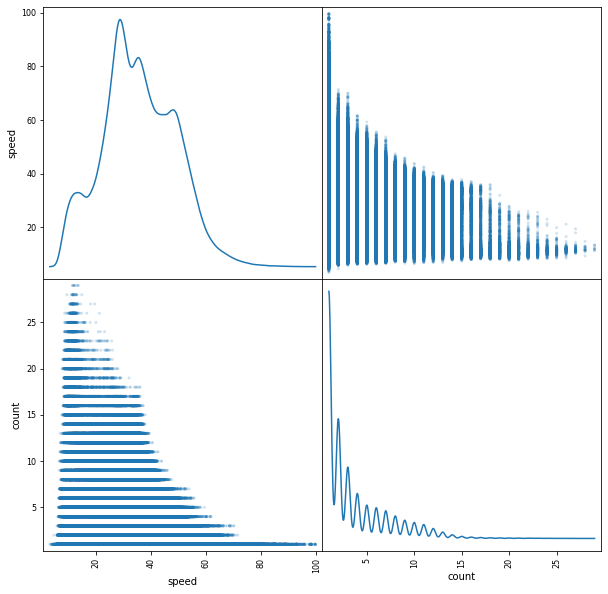

In [ ]:
pd.plotting.scatter_matrix(df_bitcarrier_mainroad_weekday[df_bitcarrier_mainroad_weekday['Corredor']=='Av. Boyacá'][['speed', 'count']], diagonal ='kde', figsize=(10,10), alpha=0.2 )


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd6d7124940>,
      dtype=object)

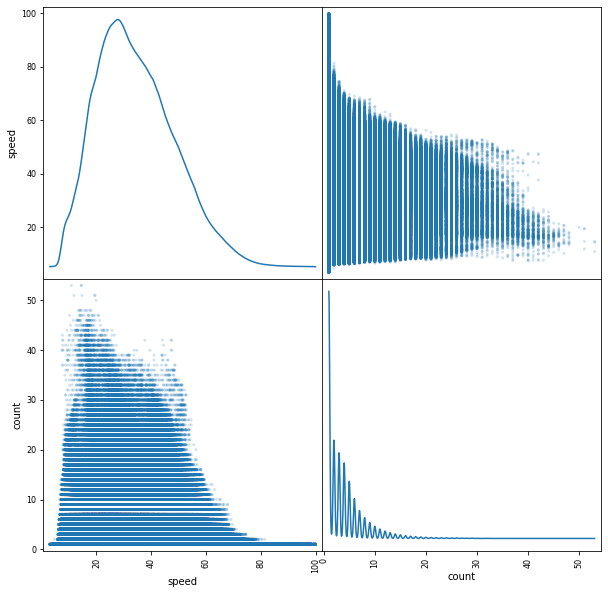

In [ ]:
pd.plotting.scatter_matrix(df_bitcarrier_mainroad_weekday[['speed', 'count']], diagonal ='kde', figsize=(10,10), alpha=0.2 )

In [35]:
fig= px.histogram(df_bitcarrier_mainroad_weekday[df_bitcarrier_mainroad_weekday['Corredor']=='Av. Boyacá'], x='speed', y='count', histfunc='sum',  title= 'Average speed for weekdays Bitcarrier Information', color ='complete_name', 
                  marginal='box', facet_col='Sentido', barmode='overlay', opacity=0.5, height=800)


#fig= px.histogram(df_bitcarrier_mainroad_weekday[1:1000], x='speed', title= 'Average speed for weekdays Bitcarrier Information')
#fig.show(renderer='notebook')
iplot(fig)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#Vamos a probar como se comporta el dato de velocidad usando promedio ponderado en lugar de velocidad promedio
#Agrupar la suma de 'count' por cada periodo agrupado. En este ejemplo es el día calendario.
weekday_grouped_count = df_bitcarrier_mainroad_weekday[df_bitcarrier_mainroad_weekday['Corredor']=='Av. Boyacá'].groupby(['tid', 'complete_name','date', 'Sentido'])['count'].agg('sum').reset_index()

fig = px.line(weekday_grouped_count, x='date', y='count', color='complete_name', facet_col='Sentido' )
#fig.show()
fig.show(renderer='colab')

In [36]:
data_table.DataTable(weekday_grouped_count)

In [37]:
# Ahora hacemos un join de la información agrupada del conteo con la data original. Con esto obtenemos el valor total de conteo para cada agrupación.

weekday_merged = df_bitcarrier_mainroad_weekday[df_bitcarrier_mainroad_weekday['Corredor']=='Av. Boyacá'].merge(weekday_grouped_count, on =['complete_name','date', 'Sentido'])
#Obtengo el peso de cada medición de bitcarrier en el total del periodo agrupado.
weekday_merged['peso'] = weekday_merged['count_x']/ weekday_merged['count_y']
weekday_merged['speed_ponderada'] = weekday_merged['speed']* weekday_merged['peso']

In [38]:
weekday_merged.columns

Index(['tid_x', 'time', 'fecha', 'levelofservice', 'speed', 'elapsed_time',
       'count_x', 'year', 'Datetime', 'cartodb_id', 'update_at', 'name_from',
       'name_to', 'distance', 'type', 'Tipo', 'Corredor', 'Sentido',
       'Observación', 'complete_name', 'complete_road', 'hour', 'day',
       'weekday', 'date', 'tid_y', 'count_y', 'peso', 'speed_ponderada'],
      dtype='object')

In [39]:
data_table.DataTable(weekday_merged[['tid_x', 'complete_name','Sentido','hour','date','fecha','weekday', 'speed', 'Corredor', 'count_x','count_y','peso', 'speed_ponderada']])

Output hidden; open in https://colab.research.google.com to view.

In [40]:
#Con la velocidad ponderada ya obtenida, agrupo la suma de velocidad de acuerdo con el periodo. En est ejemplo por dia

weekday_grouped_sum = weekday_merged[weekday_merged['Corredor']=='Av. Boyacá'].groupby(['Corredor','tid_x', 'complete_name','date', 'Sentido', 'count_y'])['speed_ponderada'].agg('sum').reset_index()
data_table.DataTable(weekday_grouped_sum)


In [41]:
fig = px.line(weekday_grouped_sum, x='date', y='speed_ponderada', color='complete_name', facet_col='Sentido', title='Velocidad ponderada tramos de la Av. Boyacá' )
fig.show()

#Como ejercicio comparativo vamos a estimar la velocidad como promedios simples y comparar con la velocidad ponderada calculada anteriormente

weekday_grouped_simple = df_bitcarrier_mainroad_weekday[df_bitcarrier_mainroad_weekday['Corredor']=='Av. Boyacá'].groupby(['tid', 'complete_name','date', 'Sentido'])['speed'].agg('mean').reset_index()

fig = px.line(weekday_grouped_simple, x='date', y='speed', color='complete_name', facet_col='Sentido', title='Velocidad promedio simple tramos de la Av. Boyacá' )
#fig.show()
fig.show(renderer='colab')

In [42]:
#Ahora vamos a estimar la velocidad promedio del corredo completo. Primero velocidad ponderada

#Agrupar la suma de 'count' por cada periodo agrupado. En este ejemplo es el día calendario.
weekday_grouped_count_corredor = weekday_grouped_sum.groupby(['Corredor','date', 'Sentido'])['count_y'].agg('sum').reset_index()

# Ahora hacemos un join de la información agrupada del conteo con la data original. Con esto obtenemos el valor total de conteo para cada agrupación.

weekday_merged_corredor = weekday_grouped_sum.merge(weekday_grouped_count_corredor, on =['Corredor','date', 'Sentido'])
#Obtengo el peso de cada medición de bitcarrier en el total del periodo agrupado.


In [43]:
data_table.DataTable(weekday_merged_corredor)

In [44]:
weekday_merged_corredor['speed_ponderada_corredor'] = weekday_merged_corredor['speed_ponderada']* weekday_merged_corredor['count_y_x']/ weekday_merged_corredor['count_y_y']
data_table.DataTable(weekday_merged_corredor)

In [45]:
weekday_grouped_sum_corredor = weekday_merged_corredor.groupby(['Corredor','date', 'Sentido'])['speed_ponderada_corredor'].agg('sum').reset_index()
data_table.DataTable(weekday_grouped_sum_corredor)

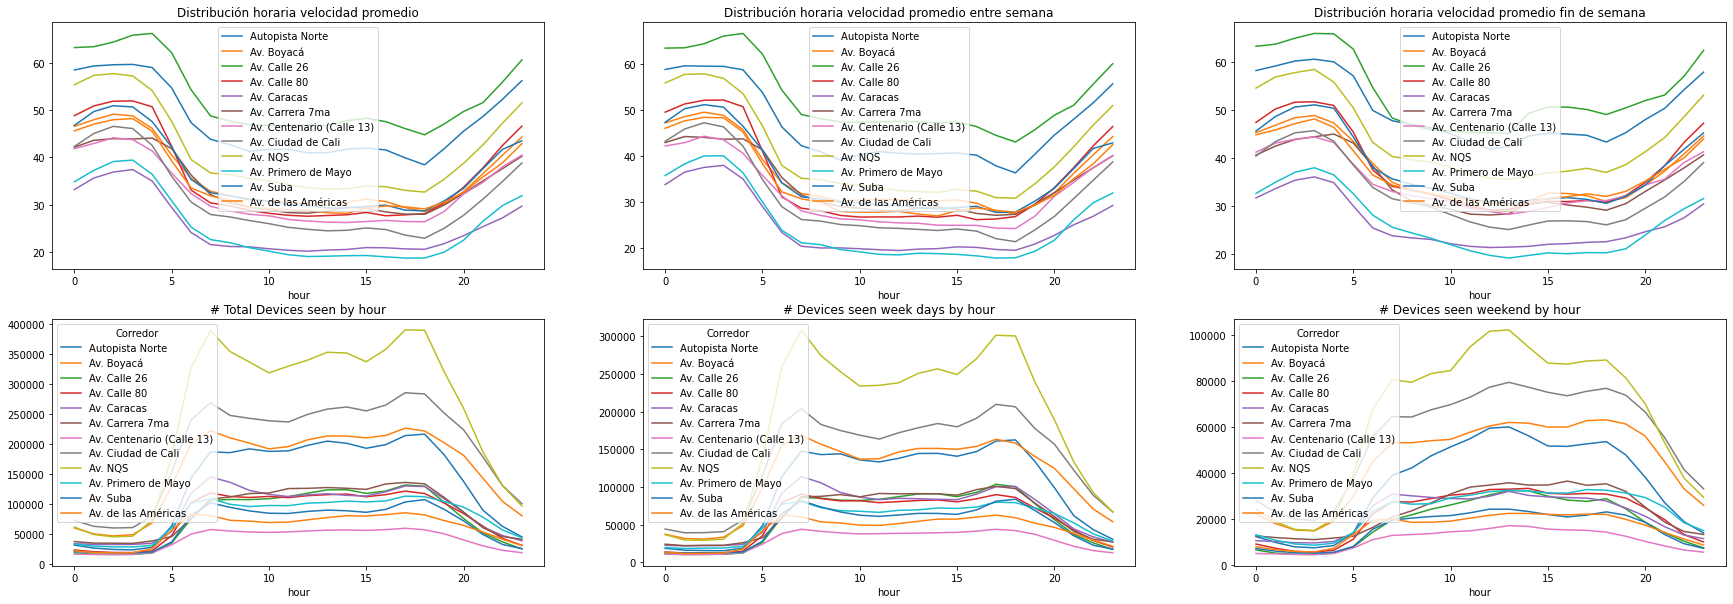

In [46]:
#PLot of average speed by main road by hour.

fig, axes = plt.subplots(2,3, figsize=(30,10))

df_bitcarrier_mainroad.groupby(['hour','Corredor'])['speed'].mean().unstack().plot(ax=axes[0,0], label='Corredor', title="Distribución horaria velocidad promedio").legend()

df_bitcarrier_mainroad_weekday.groupby(['hour','Corredor'])['speed'].mean().unstack().plot(ax=axes[0,1], label='Corredor', title="Distribución horaria velocidad promedio entre semana").legend()

df_bitcarrier_mainroad_weekend.groupby(['hour','Corredor'])['speed'].mean().unstack().plot(ax=axes[0,2], label='Corredor', title="Distribución horaria velocidad promedio fin de semana").legend()

df_bitcarrier_mainroad.groupby(['hour','Corredor'])['count'].sum().unstack().plot(ax=axes[1,0], label='Corredor', title="# Total Devices seen by hour")

df_bitcarrier_mainroad_weekday.groupby(['hour','Corredor'])['count'].sum().unstack().plot(ax=axes[1,1], label='Corredor', title="# Devices seen week days by hour")

df_bitcarrier_mainroad_weekend.groupby(['hour','Corredor'])['count'].sum().unstack().plot(ax=axes[1,2], label='Corredor', title="# Devices seen weekend by hour")

#Esta vista es muy general. Toma la velocidad de promedio de todos los "subtramos" del correor y promedia. Es una primera aproximación al comportamiento de los datos. Se debe ahondar más.

# Review Bitcarrier Shape

In [ ]:
df1 = df_bitcarrier_mainroad.groupby(['hour','Corredor'])['speed'].mean()

fig = px.line(df_bitcarrier_mainroad_weekday[df_bitcarrier_mainroad_weekday['Corredor']=='Av. Boyacá'], x='time' , y='speed', color='complete_name', hover_data=['count'])
fig.show(renderer='colab')

In [ ]:
df_bitcarrier_mainroad_weekday.head()

tid                      time  ... weekday        date
23485  141 2020-09-08 00:56:00+00:00  ...     0.0  2020-09-07
23487  141 2020-09-09 11:37:00+00:00  ...     2.0  2020-09-09
23488  141 2020-09-07 11:15:00+00:00  ...     0.0  2020-09-07
23489  141 2020-09-09 01:01:00+00:00  ...     1.0  2020-09-08
23490  141 2020-09-29 01:04:00+00:00  ...     0.0  2020-09-28

[5 rows x 25 columns]

In [ ]:
fig = px.box(df_bitcarrier_mainroad_weekday[df_bitcarrier_mainroad_weekday['Corredor']=='Av. Boyacá'], x='distance' , y='speed', color='complete_name', 
             facet_col='Sentido', hover_data=['count'])
#fig.show()
fig.show(renderer='colab')

In [ ]:
#Load bitcarrier shape file
bitcarrier_shp = gpd.read_file('/content/drive/My Drive/Team 80 DS4A/Secretaría de Movilidad - SGV/Data_Final/Bitcarrier_5min/df_bctraveltimes_geom/df_bctraveltimes_geom.shp').to_crs("EPSG:4326")

In [ ]:
#Merge shape file with main_roads key file

bitcarrier_merge=bitcarrier_shp.merge(llave_movilidad, on='tid', how='right' )


#print(bitcarrier_merge.info())
#bitcarrier_merge.head(1)

In [ ]:
#Get Geopanda of bitcarrier with geometry of the Corredores and its average speeds
bitcarrier_shp_merged = bitcarrier_merge.merge(df_bitcarrier_grouped, left_on='tid', right_on='tid')
weekday_bd = df_bitcarrier_grouped[(df_bitcarrier_grouped['weekday']<=4)]
weekend_bd = df_bitcarrier_grouped[(df_bitcarrier_grouped['weekday']>4)]

#Weekdays
bitcarrier_shp_weekdays = bitcarrier_merge.merge(weekday_bd, left_on='tid', right_on='tid' ,how='right').to_crs("EPSG:4326")

#Weekend
bitcarrier_shp_weekend = bitcarrier_merge.merge(weekend_bd, left_on='tid', right_on='tid', how='right')



In [ ]:
bitcarrier_shp_merged['complete_name']= bitcarrier_shp_merged['Corredor_x'] + " - "  + bitcarrier_shp_merged['name_to_x']

In [ ]:
#Map the average speed of corredores
bitcarrier_shp_merged= bitcarrier_shp_merged.to_crs(epsg=3857)
bitcarrier_shp_weekdays= bitcarrier_shp_weekdays.to_crs(epsg=3857)
bitcarrier_shp_weekend= bitcarrier_shp_weekend.to_crs(epsg=3857)


fig, ax = plt.subplots(3,1, figsize=(30,30))
bitcarrier_shp_merged.plot( column='speed', cmap='RdYlGn', ax=ax[0], legend=True)
ctx.add_basemap(ax[0])
ax[0].set_title('Bitcarrier total information')
plt.title('Principales corredores Bogotá - Velocidad promedio todos los días')

bitcarrier_shp_weekdays.plot( column='speed', cmap='RdYlGn', ax=ax[1], legend=True)
ctx.add_basemap(ax[1])
ax[1].set_title('Bitcarrier weekdays information')


bitcarrier_shp_weekend.plot( column='speed', cmap='RdYlGn', ax=ax[2], legend=True)
ctx.add_basemap(ax[2])
ax[2].set_title('Bitcarrier weekend information')

#The Next steps:
# Cómo graficar por hora y por dias para visualizar el cambio?
# Don't use average speed. What is the best measurement for speed?

In [ ]:
bitcarrier_shp_weekdays= bitcarrier_shp_weekdays.to_crs(epsg=4326)

In [ ]:
bitcarrier_shp_weekdays.head()


In [ ]:
import shapely.geometry

lats = []
lons = []
names = []

for feature, name in zip(bitcarrier_shp_weekdays.geometry, bitcarrier_shp_weekdays.complete_name):
    if isinstance(feature, shapely.geometry.linestring.LineString):
        linestrings = [feature]
    elif isinstance(feature, shapely.geometry.multilinestring.MultiLineString):
        linestrings = feature.geoms
    else:
        continue
    for linestring in linestrings:
        x, y = linestring.xy
        lats = np.append(lats, y)
        lons = np.append(lons, x)
        names = np.append(names, [name]*len(y))
        lats = np.append(lats, None)
        lons = np.append(lons, None)
        names = np.append(names, None)




In [ ]:
fig = px.line_mapbox(lat=lats, lon=lons,
                     mapbox_style="carto-positron", zoom=10, center={'lat': 4.61 , 'lon': -74.08}, width=600, height=800)


fig.show()

In [ ]:
lats

array([4.721750051000076, 4.731373166000027, None, ...,
       4.6243874030000685, 4.62406658500003, None], dtype=object)

In [ ]:
map_corredor = bitcarrier_shp_merged[(bitcarrier_shp_merged.Corredor_x=='Av. Boyacá')]

fig, ax = plt.subplots(1, figsize=(16,14))
map_corredor.plot( column='speed', cmap='RdYlGn', ax=ax, legend=True)
ctx.add_basemap(ax)
ax.set_title('Bitcarrier Av. Caracas')


# Waze Speed

In [ ]:
#Read waze tramos file AV. AMERICAS
waze_tramos = pd.read_excel('/content/drive/My Drive/Team 80 DS4A/Secretaría de Movilidad - SGV/Vel_Waze_STGV_AVAMERICAS_conllave.xlsx')
waze_tramos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65316 entries, 0 to 65315
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   OBJECTID         65316 non-null  int64         
 1   Id               65316 non-null  int64         
 2   Name             65316 non-null  object        
 3   FromName         65316 non-null  object        
 4   ToName           65316 non-null  object        
 5   Type             65316 non-null  object        
 6   Length           65316 non-null  int64         
 7   JamLevel         65316 non-null  int64         
 8   HistoricTime     65316 non-null  int64         
 9   Time             65316 non-null  int64         
 10  UpdateTimeMilis  65316 non-null  int64         
 11  UpdateTime       65316 non-null  datetime64[ns]
 12  Velocity         65316 non-null  float64       
 13  ReceptionTime    65316 non-null  datetime64[ns]
 14  QuarterHour      65316 non-null  objec

In [ ]:
waze_tramos = gpd.read_file('/content/drive/My Drive/Team 80 DS4A/Secretaría de Movilidad - SGV/Data_Final/Waze tramos/Waze_ago_sep.dbf')
waze_tramos.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Id          200000 non-null  object  
 1   Name        199785 non-null  object  
 2   FromName    200000 non-null  object  
 3   ToName      200000 non-null  object  
 4   Type        200000 non-null  object  
 5   Length      200000 non-null  int64   
 6   JamLevel    200000 non-null  int64   
 7   HistoricTi  200000 non-null  int64   
 8   Time        200000 non-null  int64   
 9   UpdateTime  200000 non-null  float64 
 10  UpdateTi_1  200000 non-null  object  
 11  Velocity    200000 non-null  float64 
 12  ReceptionT  200000 non-null  object  
 13  QuarterHou  200000 non-null  object  
 14  Hour        200000 non-null  object  
 15  WeekDay     200000 non-null  object  
 16  PeakHour    8558 non-null    object  
 17  geometry    0 non-null       geometry
dtypes: float64(2), g

In [ ]:
#Converting time to Date Time type
waze_tramos['Date'] = pd.to_datetime(waze_tramos['UpdateTi_1'])

#Get day, weekday
waze_tramos['year'] = waze_tramos['Date'].dt.year
waze_tramos['month'] = waze_tramos['Date'].dt.month
waze_tramos['day'] = waze_tramos['Date'].dt.day
waze_tramos['weekday'] = waze_tramos['Date'].dt.weekday

waze_tramos = waze_tramos[waze_tramos['year']==2020]
waze_tramos = waze_tramos[(waze_tramos['month']==8) | (waze_tramos['month']==9)]

#Define the key to join with bitcarrier
waze_tramos['key_waze'] = waze_tramos['Name'].str.extract(r'\((.*?)\)')


In [ ]:
waze_tramos.Time.unique()

array([ 116,  717,   91, ..., 2262, 2343, 2687])

In [ ]:
data_table.DataTable(waze_tramos)

In [ ]:
#Group waze_tramos to join with bitcarrier grouped

#waze_tramos_grouped=waze_tramos.groupby(['Corredor','name_to', 'Sentido',  'weekday', 'Hour'])['Velocity'].mean().reset_index()
#waze_tramos_grouped.head()

In [ ]:
#Merge bitcarrier with waze, to get the waze speed.

bitcarrier_mainroad_waze = df_bitcarrier_grouped.merge(waze_tramos_grouped, left_on=['NAME_TO', 'Sentido', 'weekday', 'HORA' ], right_on=['name_to', 'Sentido', 'weekday', 'Hour' ], how='left')

bitcarrier_mainroad_waze.name_to = bitcarrier_mainroad_waze.name_to.astype('category')

bitcarrier_mainroad_waze[(bitcarrier_mainroad_waze.Corredor_x)=='Av. de las Américas'].head()

NameError: ignored

In [ ]:
#Plot bitcarrier vs. Waze speed

df_temp= bitcarrier_mainroad_waze[(bitcarrier_mainroad_waze.Corredor_x)=='Av. de las Américas' ]

fig = px.scatter(df_temp[(df_temp.weekday)<=4 ], x='VEL_PROMED', y='Velocity', color='NAME_TO',  facet_col ='HORA', facet_col_wrap=4, height =1400, width = 1400, 
                 title='Speed bitcarrier vs. velocity Waze - Weekdays - Av. Americas', hover_data=['weekday'])
fig.show()

# Semáforos

In [ ]:
#Get information about traffic lights
semaforos = gpd.read_file('/content/drive/My Drive/Team 80 DS4A/Secretaría de Movilidad - SGV/Data ejemplo/Red semafórica/Red_Semaforica_de_Bogot_conllave/Red_Semaforica_de_Bogot_sincorregir.shp')


In [ ]:
display(semaforos.head())
print(semaforos.shape)

In [ ]:
semaforos['type'] = semaforos['type'].astype('category')

In [ ]:
bitcarrier_shp_merged.columns

In [ ]:
#We need to see the bitcarrier average speed vs. traffic lights to understand its impact in average

semaforos= semaforos.to_crs(epsg=3857)
fig, ax = plt.subplots(2,2, figsize=(30,30))

#map all days.
bitcarrier_shp_merged.plot( column='speed', cmap='RdYlGn', ax=ax[0,0], legend=True, zorder =1)
semaforos.plot(ax=ax[0,0], column='TIPO_INTER', cmap='tab20b', legend=True, marker ='o', markersize=15, zorder =2)
ctx.add_basemap(ax[0,0])
ax[0,0].set_title('Traffic Lights position with All Bitcarrier information')

#map weekdays
bitcarrier_shp_weekdays.plot( column='speed', cmap='RdYlGn', ax=ax[0,1], legend=True, zorder =1)
semaforos.plot(ax=ax[0,1], column='TIPO_INTER', cmap='tab20b', legend=True, marker ='o', markersize=15, zorder =2)
ctx.add_basemap(ax[0,1])
ax[0,1].set_title('Traffic Lights position with Bitcarrier weekdays information')

#map weekend
bitcarrier_shp_weekend.plot( column='speed', cmap='RdYlGn', ax=ax[1,0], legend=True, zorder =1)
semaforos.plot(ax=ax[1,0], column='TIPO_INTER', cmap='tab20b', legend=True, marker ='o', markersize=15, zorder =2)
ctx.add_basemap(ax[1,0])
ax[1,0].set_title('Traffic Lights position with Bitcarrier weekend information')
plt.title('Main roads average speed with traffic lights by type');

* We can see an effect in average speed because of traffic lights. 
* Now we can probe this impact.

In [ ]:
bitcarrier_shp_merged.info()

In [ ]:

#Merge bitcarrier main roads with traffic lights. The key columns are tid and Sentido.

bitcarrier_trafficlights = df_bitcarrier_mainroad.merge(semaforos, on=['tid','Sentido'])
bitcarrier_shp_trafficlights = bitcarrier_shp_merged.merge(semaforos, left_on=['tid','Sentido_x'],  right_on=['tid','Sentido'])

#bitcarrier_trafficlights.head()

In [ ]:
#Count number of traffic lights by bitcarrier segment

bitcarrier_trafficlights_grouped = bitcarrier_trafficlights.groupby(['Corredor_x', 'complete_name', 'Sentido', 'tid']).agg(avg_speed=('speed', 'mean'), count_traffic_lights = ('OBJECTID_1', pd.Series.nunique)).reset_index()

display(bitcarrier_trafficlights_grouped.head(10))

#bitcarrier_trafficlights[bitcarrier_trafficlights.complete_name=='AV.AMERICAS - KR36;KR62']


In [ ]:

#Scatter plot by corredor all bitcarrier information
fig = px.scatter(bitcarrier_trafficlights_grouped, x='avg_speed', y='count_traffic_lights', facet_col ='Corredor_x', facet_col_wrap=3, color='Sentido', 
                 hover_data=['Corredor_x', 'complete_name', 'Sentido', 'tid'], title='Average Speed vs. # Traffic Lights by all Bitcarrier information', height = 1000, width = 1400)

fig.show()

In [ ]:
#Count number of traffic lights by bitcarrier segment weekdays and weekend

bitcarrier_trafficlights_weekday = bitcarrier_trafficlights[(bitcarrier_trafficlights['weekday']<=4)]
bitcarrier_trafficlights_weekend = bitcarrier_trafficlights[(bitcarrier_trafficlights['weekday']>=5)]


bitcarrier_trafficlights_weekday_grouped = bitcarrier_trafficlights_weekday.groupby(['Corredor_x', 'complete_name', 'Sentido', 'tid']).agg(avg_speed=('speed', 'mean'), count_traffic_lights = ('OBJECTID_1', pd.Series.nunique)).reset_index()
bitcarrier_trafficlights_weekend_grouped = bitcarrier_trafficlights_weekend.groupby(['Corredor_x', 'complete_name', 'Sentido', 'tid']).agg(avg_speed=('speed', 'mean'), count_traffic_lights = ('OBJECTID_1', pd.Series.nunique)).reset_index()


#display(bitcarrier_trafficlights_weekday_grouped.head(10))

In [ ]:
#Scatter plot by corredor weekdays bitcarrier information
fig = px.scatter(bitcarrier_trafficlights_weekday_grouped , x='avg_speed', y='count_traffic_lights', facet_col ='Corredor_x', facet_col_wrap=3, color='Sentido', 
                 hover_data=['Corredor_x', 'complete_name', 'Sentido', 'tid'], title='Average Speed vs. # Traffic Lights by weekdays Bitcarrier information', height = 1000, width = 1400)

#fig = px.scatter(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Carrera 7ma'] , x='avg_speed', y='count_traffic_lights', facet_col ='Corredor_x', facet_col_wrap=3, color='Sentido', 
#                 hover_data=['Corredor_x', 'complete_name', 'Sentido', 'tid'], title='Average Speed vs. # Traffic Lights by weekdays Bitcarrier information', height = 1000, width = 1400)


fig.show()

In [ ]:
#Correlation
print('Correlation average speed vs. # traffic lights weekdays')
print()
print('All main roads: ' + str(round(bitcarrier_trafficlights_weekday_grouped.avg_speed.corr(bitcarrier_trafficlights_weekday_grouped.count_traffic_lights),4)))
print()
print('1. Autopista Norte: ' + str(round(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Autopista Norte'].avg_speed.corr(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Autopista Norte'].count_traffic_lights),4)))
print('2. Av. Boyacá: ' + str(round(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Boyacá'].avg_speed.corr(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Boyacá'].count_traffic_lights),4)))
print('3. Av. Caracas: ' + str(round(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Caracas'].avg_speed.corr(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Caracas'].count_traffic_lights),4)))
print('4. Av. Carrera 7ma: ' + str(round(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Carrera 7ma'].avg_speed.corr(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Carrera 7ma'].count_traffic_lights),4)))
print('5. Av. Ciudad de Cali: ' + str(round(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Ciudad de Cali'].avg_speed.corr(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Ciudad de Cali'].count_traffic_lights),4)))
print('6. Av. NQS: ' + str(round(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. NQS'].avg_speed.corr(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. NQS'].count_traffic_lights),4)))
print('7. Av. Primero de Mayo: ' + str(round(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Primero de Mayo'].avg_speed.corr(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Primero de Mayo'].count_traffic_lights),4)))
print('8. Av. Suba: ' + str(round(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Suba'].avg_speed.corr(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Suba'].count_traffic_lights),4)))
print('9. Av. Calle 26: ' + str(round(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Calle 26'].avg_speed.corr(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Calle 26'].count_traffic_lights),4)))
print('10. Av. Calle 80: ' + str(round(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Calle 80'].avg_speed.corr(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Calle 80'].count_traffic_lights),4)))
print('11. Av. Centenario (Calle 13): ' + str(round(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Centenario (Calle 13)'].avg_speed.corr(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. Centenario (Calle 13)'].count_traffic_lights),4)))
print('12. Av. de las Américas: ' + str(round(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. de las Américas'].avg_speed.corr(bitcarrier_trafficlights_weekday_grouped[(bitcarrier_trafficlights_weekday_grouped.Corredor_x)=='Av. de las Américas'].count_traffic_lights),4)))


In [ ]:
#Scatter plot by corredor weekend bitcarrier information
fig = px.scatter(bitcarrier_trafficlights_weekend_grouped , x='avg_speed', y='count_traffic_lights', facet_col ='Corredor_x', facet_col_wrap=3, color='Sentido', 
                 hover_data=['Corredor_x', 'complete_name', 'Sentido', 'tid'], title='Average Speed vs. # Traffic Lights by weekends Bitcarrier information', height = 1000, width = 1400)

fig.show()